## Install

In [ ]:
!git clone -b main https://github.com/khalil-research/PyEPO.git
!pip install PyEPO/pkg/.
!git clone https://github.com/CPMpy/cpmpy.git
!pip install cpmpy

Cloning into 'PyEPO'...
remote: Enumerating objects: 20319, done.
remote: Counting objects: 100% (5042/5042), done.
remote: Compressing objects: 100% (3027/3027), done.
remote: Total 20319 (delta 2005), reused 4972 (delta 1953), pack-reused 15277
Receiving objects: 100% (20319/20319), 320.71 MiB | 19.33 MiB/s, done.
Resolving deltas: 100% (7687/7687), done.
Processing ./PyEPO/pkg
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.6 MB/s eta 0:00:00
  Created wh

# Knapsack Solution Visualization

We utilize a technique of visualizing predicted-then-optimized results in order to gain an intuitive understanding of the performance variations among the various approaches.

In this study, the knapsack problem is utilized as an exemplar.  The knapsack problem is a combinatorial optimization problem that seeks to find the most valuable set of items to include in a knapsack, subject to constraints on the total weight of the items.

## 1 Preparation

### 1.1 Libraries

Let's import useful libraries.

In [ ]:
import time
import random
import pyepo
import torch
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
import pandas as pd


Auto-Sklearn cannot be imported.


Then, we set the random seed for reproducibility.

In [ ]:
# fix random seed
random.seed(135)
np.random.seed(135)
torch.manual_seed(135)

### 1.2 Visualization Functions

Define functions that visualize a solution to a knapsack instance.

In [ ]:
# plot function
def plotSol(m, c, w, weights, caps, caption=None, cp=None):
    # colors
    cmap = cm.get_cmap("plasma")(np.linspace(0, 1, m))
    # get list
    sol, val, cap1, cap2, cpred = [], [], [], [], []
    for i in range(m):
        sol.append(3)
        val.append(c[i] * w[i])
        cap1.append(weights[0,i] * w[i])
        cap2.append(weights[1,i] * w[i])
        if cp is not None:
          cpred.append(cp[i] * w[i])
    # init fig
    fig = plt.figure(figsize=(8,4))
    plt.gca().invert_yaxis()
    acc = [0, 0, 0, 0]
    # bar plot
    if cp is None:
      for i in range(m):
          bar = [sol[i], val[i], cap1[i], cap2[i]]
          plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
          # not selected
          if not int(w[i]):
              # grey color
              bar = [sol[i], 0, 0, 0]
              plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
              plt.barh(range(4), bar, left=acc, color="lightgrey", height=0.75, edgecolor="w", linewidth=2, alpha=0.9)
          acc = [acc[0]+sol[i], acc[1]+val[i], acc[2]+cap1[i], acc[3]+cap2[i]]
    else:
      acc = [0, 0, 0, 0, 0]
      for i in range(m):
          bar = [sol[i], val[i], cpred[i], cap1[i], cap2[i]]
          plt.barh(range(5), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
          # not selected
          if not int(w[i]):
              # grey color
              bar = [sol[i], 0, 0, 0, 0]
              plt.barh(range(5), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
              plt.barh(range(5), bar, left=acc, color="lightgrey", height=0.75, edgecolor="w", linewidth=2, alpha=0.9)
          acc = [acc[0]+sol[i], acc[1]+val[i], acc[2]+cpred[i], acc[3]+cap1[i], acc[4]+cap2[i]]

    # total value
    tval = sum(val)
    plt.text(tval+0.5, 1.1, tval, fontsize=12)
    # vertical line
    if cp is None:
      plt.axvline(x=caps[0], ymin=0.27, ymax=0.48, color="firebrick", linewidth=1.5)
      plt.text(caps[0]+0.5, 2.1, "Capacity 1", fontsize=12, color="firebrick")
      plt.axvline(x=caps[1], ymin=0.03, ymax=0.24, color="firebrick", linewidth=1.5)
      plt.text(caps[1]+0.5, 3.1, "Capacity 2", fontsize=12, color="firebrick")
    else:
      # total predicted value
      tpredval = sum(cpred)
      plt.text(tpredval+0.5, 2.1, "%.2f"%tpredval, fontsize=12)
      plt.axvline(x=caps[0], ymin=0.23, ymax=0.38, color="firebrick", linewidth=1.5)
      plt.text(caps[0]+0.5, 3.1, "Capacity 1", fontsize=12, color="firebrick")
      plt.axvline(x=caps[1], ymin=0.03, ymax=0.2, color="firebrick", linewidth=1.5)
      plt.text(caps[1]+0.5, 4.1, "Capacity 2", fontsize=12, color="firebrick")

    # labels and ticks
    plt.xticks([])
    bar_labels = ["Items Selection", "Items Groundtruth Value", "Resource 1", "Resource 2"] if cp is None else ["Items Selection", "Items Groundtruth Value", "Items Predicted Value", "Resource 1", "Resource 2"]
    plt.yticks(range(len(bar_labels)), bar_labels, fontsize=16)
    plt.minorticks_off()
    plt.tick_params(axis='both', length=0)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.title(caption, fontsize=18)
    plt.show()
    return fig

In [ ]:
def prep_plotSol(data_loader, optmodel, ind=0, pytorch_model=None, sklearn_model=None, method_name=None):
  # extract solutions by iterating over data loader (pytorch does not provide indexing into it)
  for i, data in enumerate(loader_test):
      if i == ind:
        # load data
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # convert to numpy
        c = c.to("cpu").detach().numpy()[0]
        w = w.to("cpu").detach().numpy()[0]
        z = z.to("cpu").detach().numpy()[0]

        # predict
        if pytorch_model is not None:
          cp = pytorch_model(x)
          cp = cp.to("cpu").detach().numpy()
          # solve
          optmodel.setObj(cp[0])
          wp, _ = optmodel.solve()
        elif sklearn_model is not None:
          x = x.to("cpu").detach().numpy()
          cp = sklearn_model.predict(x)
          wp, _ = optmodel.solve()
        else:
          cp = [None]
          wp = w
          method_name = "Groundtruth objective coefficients"

        fig = plotSol(m, c, wp, weights, caps, method_name, cp[0])
        break

In [ ]:
def plotLearningCurve(loss_log, method):
    # draw loss during training
    plt.figure(figsize=(8, 4))
    plt.plot(loss_log, color="c")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlim(-1, len(loss_log)+1)
    plt.xlabel("Iters", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("%s: Learning Curve on Training Set" % method, fontsize=12)
    plt.show()


### 1.3 Optimization Model, Dataset and Data Loader

#### Data Generation

We generate a synthetic knapsack dataset where the values of the items $\mathbf{c}$ are unknown and can be predicted from features $\mathbf{x}$. Additionally, the data generator provides the weights of the items. Since the constraints are fixed, the item weights are the same for all instances. Check section 5.1.2 of our paper (https://arxiv.org/abs/2206.14234) to learn more about the generation process.

In [ ]:
# generate data for 2D knapsack
m = 16 # number of items
n = 100 # number of training data
n_test = 1000
p = 5 # number of features for each instance
deg = 6 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [20] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+n_test, p, m, deg=deg, dim=dim, noise_width=noise_width)

In [ ]:
# data split
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

#### Optimization Model

We use CPMpy to build a binary linear programming model for the knapsack problem. For more details on the ``optModel`` class, you can read tutorial [01 Optimization Model
](https://github.com/khalil-research/PyEPO/blob/main/notebooks/01%20Optimization%20Model.ipynb) and [documentation](https://khalil-research.github.io/PyEPO/build/html/content/examples/model.html).

In [ ]:
from pyepo.model.opt import optModel
from pyepo import EPO
import cpmpy as cpm

class knapsackModel(optModel):
    """
    This class is an optimization model for knapsack problem

    Attributes:
        _model (model): a CPMpy model
        weights (np.ndarray / list): Weights of items
        capacity (np.ndarray / listy): Total capacity
        items (list): List of item indices
    """

    def __init__(self, weights, capacity):
        """
        Args:
            weights (np.ndarray / list): weights of items
            capacity (np.ndarray / list): total capacity
        """
        self.weights = np.array(weights)
        self.capacity = np.array(capacity)
        self.items = list(range(self.weights.shape[1]))
        self.modelSense = EPO.MAXIMIZE
        super().__init__()

    def _getModel(self):
        """
        A method to build CPMpy model

        Returns:
            tuple: optimization model and variables
        """
        # ceate a model
        # model = cpm.Model()
        model = cpm.SolverLookup.get("gurobi")

        # varibles
        x = cpm.intvar(0, 1, shape=(len(self.items)))
        # constraints
        for i in range(len(self.capacity)):
            model += (cpm.sum(self.weights[i,j] * x[j]
                        for j in self.items) <= self.capacity[i])
        return model, x

    def setObj(self, c):
        """
        A method to set objective function

        Args:
            c (np.ndarray): cost of objective function
        """
        # vector to matrix
        self._model.maximize(cpm.sum(c[j] * self.x[j] for j in range(len(self.items))))

    def solve(self):
        """
        A method to solve model

        Returns:
            tuple: optimal solution (list) and objective value (float)
        """
        if not self._model.solve():
            print("No solution found.")
        # uncomment to print solver run time
        # print(self._model.status())

        sol = self.x.value()#np.array([self.x[i].value() for j in self.items])
        return sol, self._model.objective_value()/1.0

This is the optimization model object with fixed knapsack constraints and an objective function that will be set based on ML model predictions.

In [ ]:
optmodel = knapsackModel(weights, caps)

Restricted license - for non-production use only - expires 2024-10-28


#### Dataset and Data Loader

PyTorch provides ``Dataset`` to stores the samples $\mathbf{x}$ and their corresponding costs $\mathbf{c}$. Besides storing $\mathbf{x}$ and $\mathbf{c}$, ``optDataset`` uses solver to find the corresponding optimal solutions $\mathbf{w}^*$ and objective values $\mathbf{z}^*$ per instance.

More details on ``optDataset`` is [here](https://github.com/khalil-research/PyEPO/blob/main/notebooks/02%20Optimization%20Dataset.ipynb).

In [ ]:
# get training data set
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
# get test data set
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 253.29it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:01<00:00, 533.88it/s]


``DataLoader`` wraps an iterable around the Dataset to enable easy access to the samples.

In [ ]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 16
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

### 1.4 PyTorch Linear Regression

In PyTorch, the ``nn.Module`` is a base class for all neural network modules in the library. It provides a convenient way to organize the layers of a model, and to define the forward pass of the model.

Here, we build the simplest PyTorch model, a multi-output linear regression model. There are $p$ input features for each knapsack instance (or data point) and the model outputs $m$ predictions, one for each item's value (or objective function coefficient).

In [ ]:
from torch import nn
# build linear model
class LinearRegressionNN(nn.Module):

    def __init__(self):
        super(LinearRegressionNN, self).__init__()
        self.linear = nn.Linear(p, m)

    def forward(self, x):
        out = self.linear(x)
        return out

# build linear model
class NN(nn.Module):

    def __init__(self):
        super(NN, self).__init__()
        self.linear1 = nn.Linear(p, m)
        self.linear2 = nn.Linear(m, m)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.linear2(self.relu(self.linear1(x)))
        return out

## 2 Solution Visualization

We present a visual representation of solutions to the knapsack problem obtained from a variety of methods. All apply to the same instance of the problem. The visualization includes five rows, with the first row depicting the items selected, the second row depicting the corresponding total value based on the grountruth item values, the third row depicting what a given ML model predicted those values to be, and the last two rows displaying the capacity constraints. This visual representation serves to provide an intuitive understanding of the solutions obtained through the different methods.

### 2.1 Optimal Solution

True optimal solution for current instance based on the groundtruth objective coefficients.

<ipython-input-4-7184b90fe925>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("plasma")(np.linspace(0, 1, m))


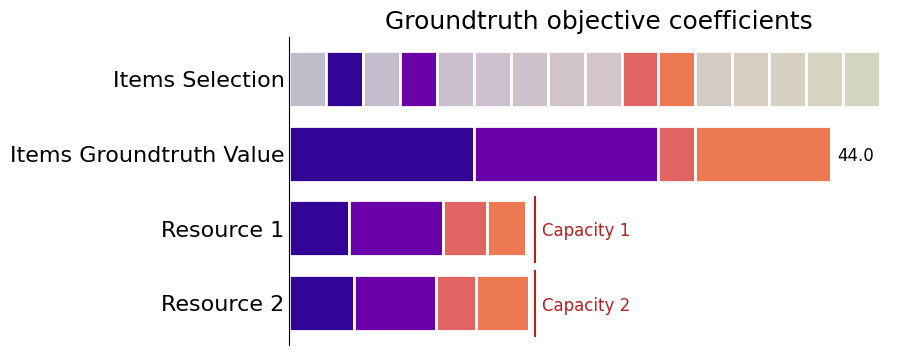

In [ ]:
prep_plotSol(loader_test, optmodel, ind=0, pytorch_model=None, method_name=None)

### 3 Training ML models

Generic training loop

In [ ]:
def train_model(pytorch_model, loss_function, method_name, data_loader, num_epochs=20):
  # set optimizer; its learning rate (lr) hyperparameter may benefit from tuning
  optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=1e-1)
  # set model to training mode
  pytorch_model.train()
  loss_log = []
  tbar = tqdm(range(num_epochs))
  # L1 loss, used in some methods
  l1 = nn.L1Loss()
  l2 = nn.MSELoss()

  for epoch in tbar:
      # iterate over data mini-batches
      for i, data in enumerate(data_loader):
          x, c, w, z = data
          # cuda
          if torch.cuda.is_available():
              x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
          # forward pass
          cp = pytorch_model(x)
          if method_name == 'spoplus':
            # spo+ loss
            loss = loss_function(cp, c, w, z).mean()
          elif method_name == 'pfyl':
            # pfyl loss
            loss = loss_function(cp, w).mean()
          elif method_name == 'dbb':
            # black-box optimizer
            wp = loss_function(cp)
            # objective value
            zp = (wp * c).sum(1).view(-1, 1)
            # regret loss
            loss = l1(zp, z)
          elif method_name == 'dpo':
            # perturbed optimizer
            we = loss_function(cp)
            # loss
            loss = l2(we, w)
          elif method_name == 'nce' or 'ranking' in method_name:
            # noise contrastive estimation
            loss = loss_function(cp, c)
          elif method_name == '2stage':
            loss = loss_function(cp, c)

          loss += 10*l2(cp, c)

          loss_log.append(loss.item())
          # backward pass
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
  elapsed = tbar.format_dict["elapsed"]
  print(elapsed)

  return loss_log, elapsed

This is where 8 kinds of methods are used. "2stage" stands for the separated prediction (of objective coefficients) then optimization approach. The next 7 methods leverage a variety of different loss functions with varying computational efficiencies.

Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
Num of cores: 2
2stage


Epoch: 49, Loss: 30.5294: 100%|██████████| 50/50 [00:01<00:00, 29.73it/s]


1.683363914489746


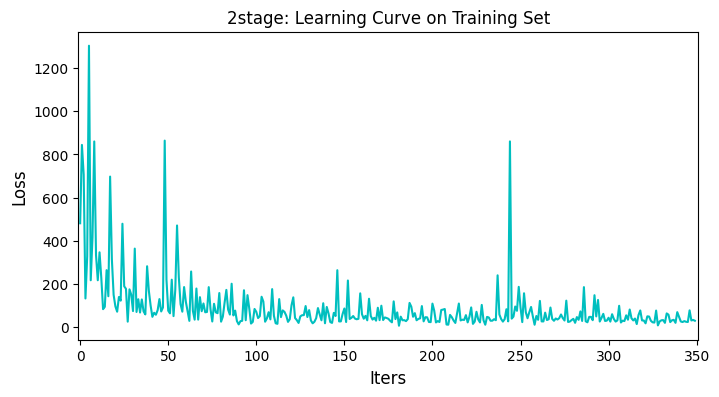

****** 2stage: Regret on test set: 9.40% after 1.68 sec of training ******


<ipython-input-4-7184b90fe925>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("plasma")(np.linspace(0, 1, m))


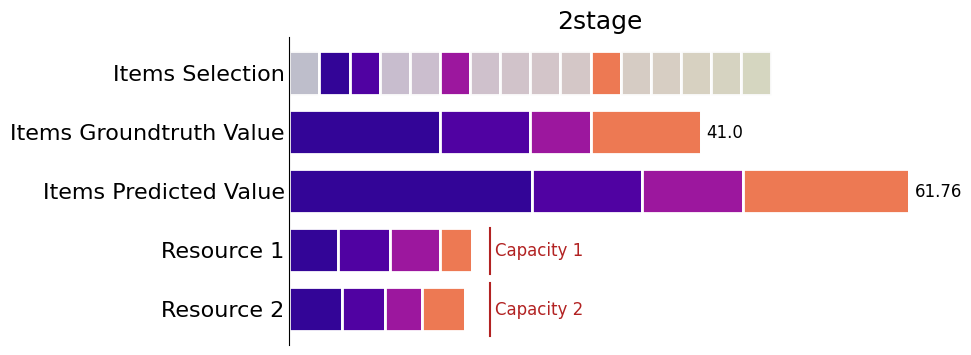

-------------------------------------------
spoplus


Epoch: 49, Loss: 40.0988: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


33.371116399765015


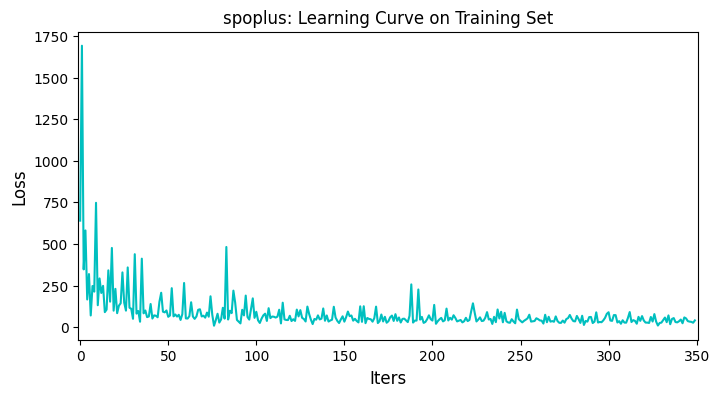

****** spoplus: Regret on test set: 9.07% after 33.37 sec of training ******


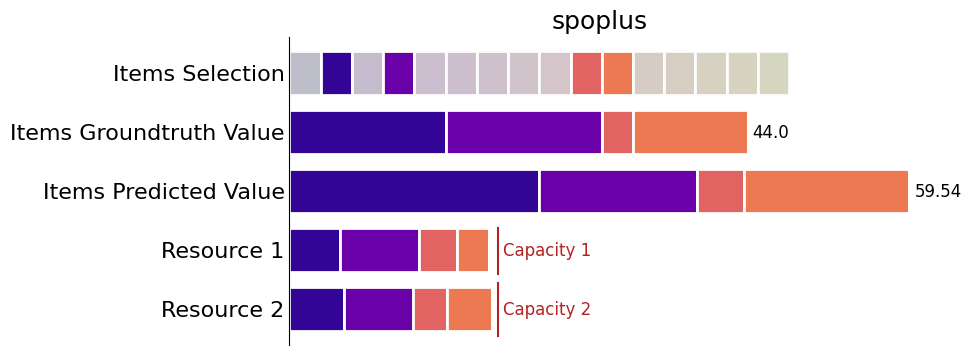

-------------------------------------------
dbb


Epoch: 49, Loss: 201.8648: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


61.457526445388794


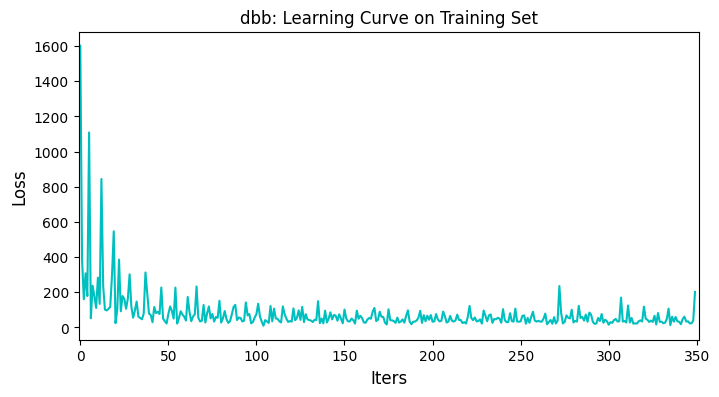

****** dbb: Regret on test set: 10.02% after 61.46 sec of training ******


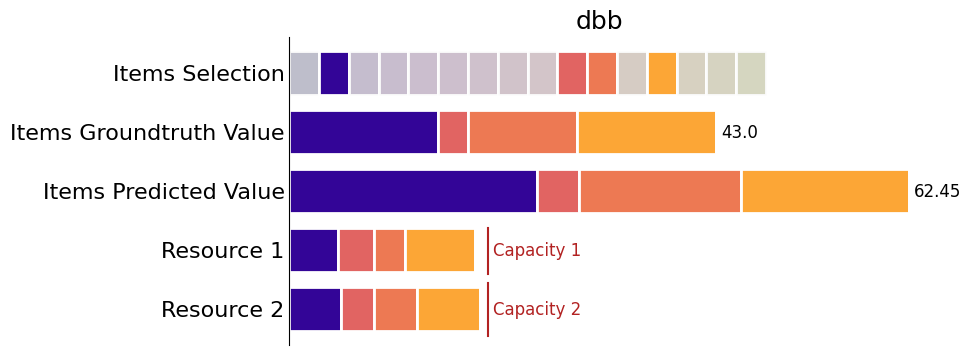

-------------------------------------------
dpo


Epoch: 49, Loss: 29.8846: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


35.45900082588196


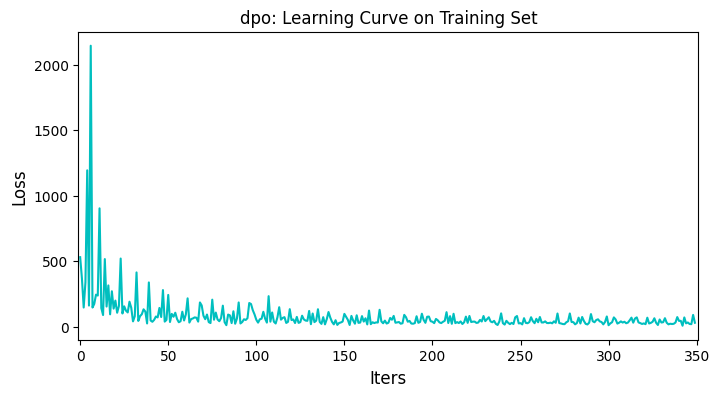

****** dpo: Regret on test set: 8.86% after 35.46 sec of training ******


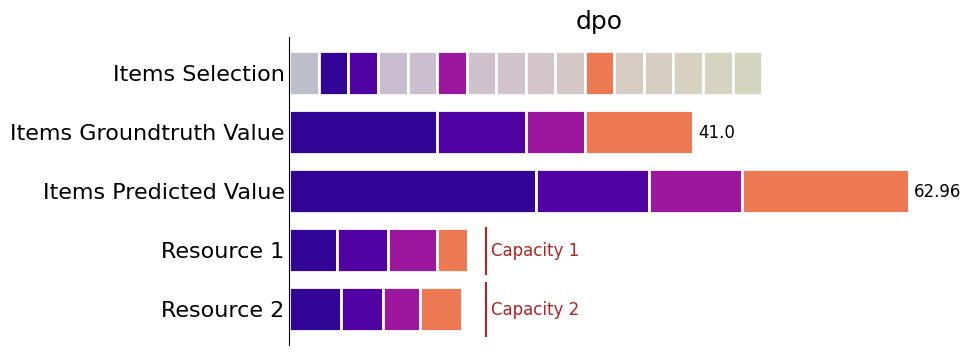

-------------------------------------------
pfyl


Epoch: 49, Loss: 38.7921: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


33.60910201072693


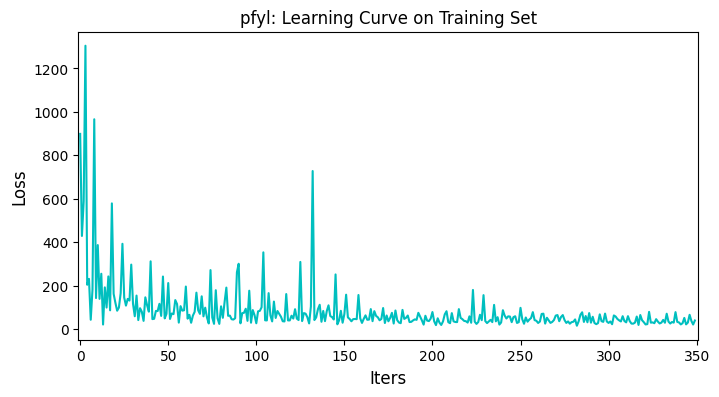

****** pfyl: Regret on test set: 9.75% after 33.61 sec of training ******


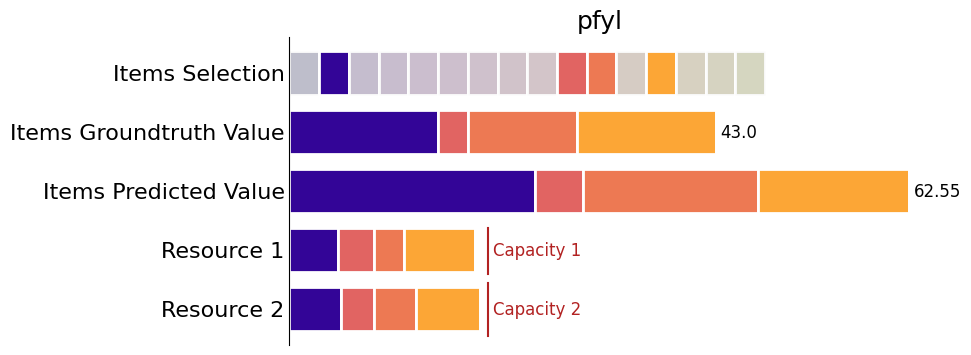

-------------------------------------------
listwiseranking


Epoch: 49, Loss: 125.3478: 100%|██████████| 50/50 [00:04<00:00, 11.19it/s]


4.469660997390747


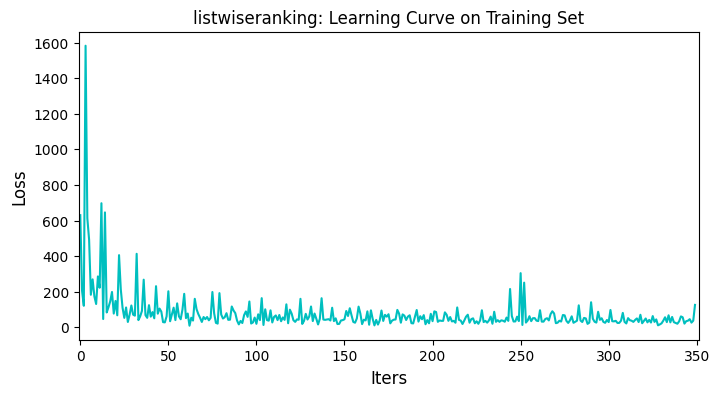

****** listwiseranking: Regret on test set: 9.85% after 4.47 sec of training ******


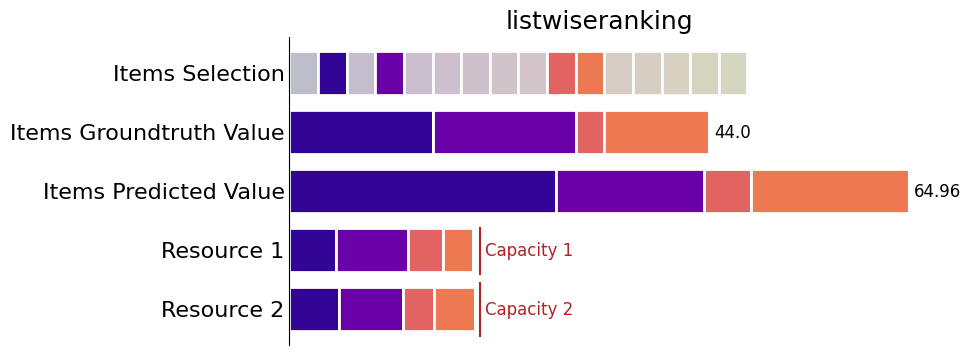

-------------------------------------------
pairwiseranking


Epoch: 49, Loss: 37.8775: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


22.005547523498535


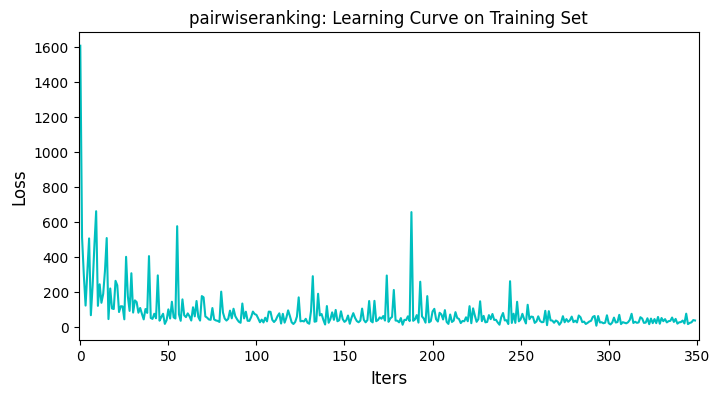

****** pairwiseranking: Regret on test set: 10.49% after 22.01 sec of training ******


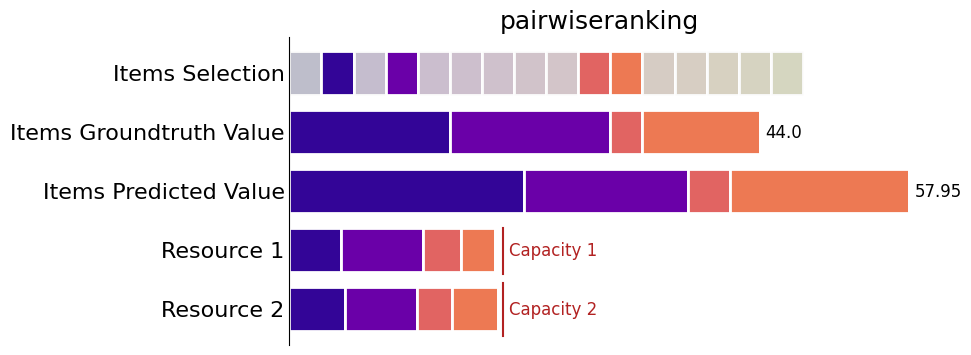

-------------------------------------------
pointwiseranking


Epoch: 49, Loss: 58.5208: 100%|██████████| 50/50 [00:04<00:00, 11.13it/s]


4.49426007270813


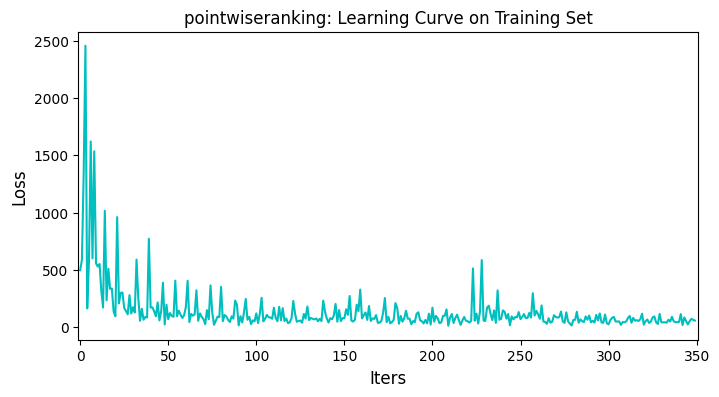

****** pointwiseranking: Regret on test set: 10.86% after 4.49 sec of training ******


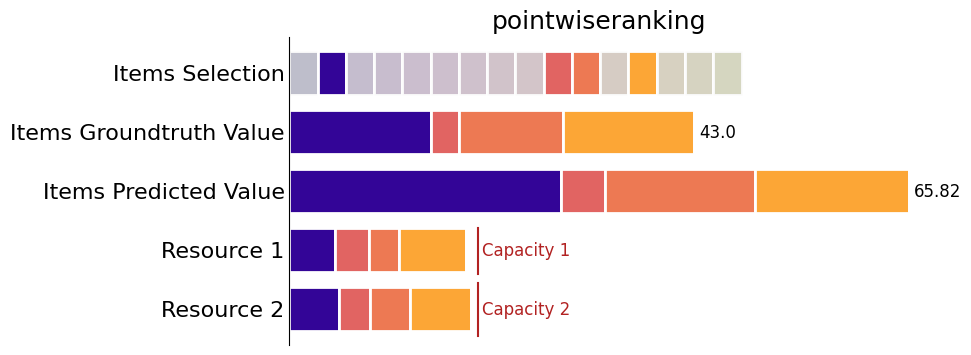

-------------------------------------------


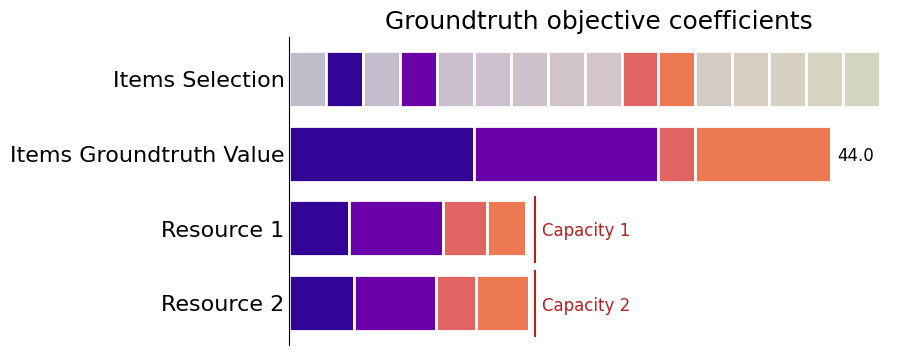

In [ ]:
num_processes = 2 # Colab provides 2 cores
num_epochs = 50
loss_dict = {
    '2stage':nn.MSELoss(),
    'spoplus':pyepo.func.SPOPlus(optmodel, processes=num_processes),
    'dbb':pyepo.func.blackboxOpt(optmodel, lambd=20, processes=num_processes),
    'dpo':pyepo.func.perturbedOpt(optmodel, n_samples=1, sigma=0.5, processes=num_processes),
    'pfyl':pyepo.func.perturbedFenchelYoung(optmodel, n_samples=1, sigma=0.5, processes=num_processes),
    'listwiseranking':pyepo.func.listwiseLTR(optmodel, processes=num_processes, solve_ratio=0.05, dataset=dataset_train),
    'pairwiseranking':pyepo.func.pairwiseLTR(optmodel, processes=num_processes, solve_ratio=0.05, dataset=dataset_train),
    'pointwiseranking':pyepo.func.pointwiseLTR(optmodel, processes=num_processes, solve_ratio=0.05, dataset=dataset_train)
}

for method, loss_function in loss_dict.items():
  print(method)
  # init model
  # reg = LinearRegressionNN()
  reg = NN()
  # use cuda if GPU is enabled
  if torch.cuda.is_available():
      reg = reg.cuda()

  loss_log, time_elapsed = train_model(reg, loss_function, method, loader_train, num_epochs=num_epochs)

  plotLearningCurve(loss_log, method)

  regret_test = pyepo.metric.regret(reg, optmodel, loader_test)
  print("****** %s: Regret on test set: %.2f%% after %.2f sec of training ******" % (method, regret_test*100, time_elapsed))

  # change the value of parameter "ind" to an integer less than n_test (by default 1000) to visualize other instances
  prep_plotSol(loader_test, optmodel, ind=0, pytorch_model=reg, method_name=method)

  print("-------------------------------------------")
prep_plotSol(loader_test, optmodel, ind=0, pytorch_model=None, method_name=None)
